In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# from time import clock, sleep
# from datetime import datetime as dt
from scipy.stats import norm, uniform, multivariate_normal as multinorm
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
np.set_printoptions(edgeitems=10, linewidth=120, suppress=True, precision=16)
from scipy.stats import gaussian_kde as kde

from pertussis import *

2017-10-31-07-54-52.log


In [2]:
# logger.setLevel(logging.WARNING)

# Initial
r_start = 1929
r_end = 2014
step = 1 / N

# Data
data_M, months = cases_monthly()
# data_M = ma.array(data_M)
# data_M[data_M > 150] = 150 #ma.masked
state_0 = collect_state0()

(192,) (3, 192)


# Make Model

## Distributions

In [3]:
dist_om = uniform(3.5,1)
dist_phi = uniform(0, 2 * np.pi)
dist_rho = uniform(1, 99)
dist_f   = uniform(0.00, 0.5)
dist_e   = uniform(0.5,0.5)
dists = [dist_om, dist_phi, dist_rho, dist_f, dist_f, dist_f, dist_e]
# dists = [dist_om, dist_phi, dist_f, dist_f, dist_f, dist_f, dist_e]

## Build MCMC
### Initialize or Load

In [5]:
# Load
vers = 'chains/1030'
vers = ''
print ('./' + vers)
mcmcs = [load_mcmc('./' + vers + 'mcmc_{}.pkl'.format(i)) for i in range(3)]
mcmcs[1]['active'] = False

./


In [8]:
len(mcmcs[1]['chain'])

2205

In [4]:
#6,6,7
extra_params = dict (cov = np.diag((0.2, np.pi / 10, 0.2, 5e-6, 5e-6, 5e-6)),
                    datax=data_M,
                    dists=dists,
                    names = ['omega','phi','rho','f1','f2','f3'], 
                    datay = months,
                    active_params = [1,3,4,5],
                    sigma = 50)

In [5]:
# Initialize
np.random.seed(314)
# om, phi, rho, f1, f2, f3, e =  3.9805, 1.448521980511,  50,   0.000834353366,   0.000422725519,   0.000069343251, 1
om, phi, rho, f1, f2, f3, e =  3.9805, 1.45,  50,   0.0008,   0.0004,   0.00007, 1
mcmc0 = init_mcmc('mcmc_0', state_0, r_start, r_end, om, phi, rho, f1, f2, f3,
                 **extra_params)

om, phi, rho, f1, f2, f3, e = 3.9805,   np.pi,  50,   0.0010,   0.00125,   0.00008,   1
mcmc1 = init_mcmc('mcmc_1', state_0, r_start, r_end, om, phi, rho, f1, f2, f3, 
                 **extra_params)

om, phi, rho, f1, f2, f3, e =  3.9805, 2.8256, 50,  0.0012, 0.0003, 0.0001, 1
mcmc2 = init_mcmc('mcmc_2', state_0, r_start, r_end, om, phi, rho, f1, f2, f3, 
                 **extra_params)

om, phi, rho, f1, f2, f3, e =  3.9805, np.pi / 2, 50,  0.009, 0.0005, 0.00006, 1
mcmc3 = init_mcmc('mcmc_3', state_0, r_start, r_end, om, phi, rho, f1, f2, f3, 
                 **extra_params)

mcmcs = [mcmc0, mcmc1, mcmc2, mcmc3]

[ 1.45    0.0008  0.0004  0.0001] (3.9805, 1.45, 50, 0.0008, 0.0004, 7e-05)
[ 3.1416  0.001   0.0013  0.0001] (3.9805, 3.141592653589793, 50, 0.001, 0.00125, 8e-05)
[ 2.8256  0.0012  0.0003  0.0001] (3.9805, 2.8256, 50, 0.0012, 0.0003, 0.0001)
[ 1.5708  0.009   0.0005  0.0001] (3.9805, 1.5707963267948966, 50, 0.009, 0.0005, 6e-05)


In [6]:
mcmc0 = mcmcs[0]
np.set_printoptions(edgeitems=10, linewidth=120, suppress=True, precision=16)
# print(mcmc0['active_params'])
# type(mcmc0['cov'])
print (mcmc0['cov'])
print (mcmc0['cov'].shape)
print (mcmc0['chain'].shape)
print (mcmc0['initial_guess'])
print (mcmc0['gelman_rubin'][-1])

[[ 0.3141592653589793  0.                  0.                  0.                ]
 [ 0.                  0.000005            0.                  0.                ]
 [ 0.                  0.                  0.000005            0.                ]
 [ 0.                  0.                  0.                  0.000005          ]]
(4, 4)
(4,)
[  3.9805000000000001   1.45                50.                   0.0008               0.0004               0.00007           ]
0.0


In [6]:
for mc in mcmcs[0:]:
    mc['active'] = True 
all([mc['active'] for mc in mcmcs])

True

In [7]:
logger.setLevel(logging.INFO)

### Loop

In [9]:
np.set_printoptions(edgeitems=10, linewidth=120, suppress=True, precision=8)
iterations = 5000
j=0
recalculate = 250
sd_stop_after = 5000
scaling_stop_after = 5000
do_gelman_rubin = True

for iteration in tqdm(range(1, iterations)):
    logger.info('-'*20 + ' '*10 + 'Iteration {} '.format(len(mcmcs[0]['accepted'])) + ' '*10 + '-'*30)
    # Every few iterations, some global changes need to be done.
    test_condition = len(mcmcs[0]['chain']) % recalculate == 0 ## When to test
    
    # Compute gelman rubin
    if test_condition and do_gelman_rubin:
        if sum([mc['active'] for mc in mcmcs]) > 1:
            print ("Gelman Rubin")
            gr_curr = gelman_rubin(make_chains(mcmcs))
            mcmcs[0]['gelman_rubin'] = np.vstack((mcmcs[0]['gelman_rubin'], gr_curr))
            if np.all(gr_curr < 1.1):
                mcmcs[0]['gr_where'] = iterations
                print ("Gelman Rubin Converged " + str(iteration))
                for mc in mcmcs[1:]:
                    mc['active'] = False
                sd_stop_after = 0
                scaling_stop_after = 0
                do_gelman_rubin = False
            if len(mcmcs[0]['chain']) > 2000:
                for gri in range(len(mcmcs)-1):
                    for grj in range (gri+1, len(mcmcs)):
                        if (mcmcs[gri]['active']) and (mcmcs[grj]['active']):
                        grtmp = gelman_rubin(make_chains([mcmcs[gri],mcmcs[grj]]))
                        if all(grtmp < 1.1):
                            mcmcs[grj]['active'] = False
                            save_mcmc(mcmcs[grj])
                            print ("Shutting off {} by {}".format(mcmcs[grj]['name'],mcmcs[gri]['name']))
                            print (grtmp)
                            
    
    compute_new_sd = len(mcmcs[0]['chain']) < sd_stop_after
    compute_scaling_factor = len(mcmcs[0]['chain']) < scaling_stop_after            
        
        
    for mcmc in mcmcs:
        if not (mcmc['active']): # When G-R converges, stop running all but one. -conition on GRB
            continue
        logger.info('*** Chain {}'.format(mcmc['name']) + '-'*15)
        
        # Save Chain
        if len(mcmc['chain']) % 50 == 5:
            save_mcmc(mcmc)
        if test_condition:
            # acceptance rate
            accept_star = np.mean(mcmc['accepted'][-recalculate:])
            mcmc['rates'] = np.append(mcmc['rates'], accept_star)
            # new scaling factor - pg. 24
            if compute_scaling_factor:
                new_scaling_factor = mcmc['scaling_factor'][-1]
#                 new_scaling_factor *= np.e ** ((accept_star - mcmc['accept_hat']) / len(mcmc['scaling_factor']))
                new_scaling_factor *= np.e ** (accept_star - mcmc['accept_hat'])
                mcmc['scaling_factor'] = np.append(mcmc['scaling_factor'], new_scaling_factor)
            else:
                new_scaling_factor = 1
            # new cov pg. 24            
            if compute_new_sd:
                new_cov_tmp = mcmc['cov']
                try:
                    sigma_star = np.cov(mcmc['chain'][-recalculate:,:].T)
                    new_cov = mcmc['cov'].copy() * 0.25 + 0.75 * sigma_star
                    proposed = multinorm(mcmc['values'], new_cov * new_scaling_factor**2)
                    mcmc['cov'] = new_cov
                except:
                    print ("Singular COV at", len(mcmc['accepted']),mcmc['name'])
                    mcmc['cov'] = new_cov_tmp        
            mcmc['sd'] = new_scaling_factor ** 2 * mcmc['cov']

        # Current Stats
        ll_now = log_liklihood(mcmc['y_now_M'], data_M, mcmc['sigma'])
        
        # Pick new set
        try:
            proposed = multinorm(mcmc['values'], mcmc['sd']) # Try new set ***************************************
        except Exception as e:
            print (e)
            print (mcmc['name'], "TUNRED OFF", len(mcmc['accepted']))
            mcmc['active'] = False
        guess = proposed.rvs()
        g = mcmc['initial_guess']
        g[mcmc['active_params']] = guess
        # Check if possible set
        g[1] %= 2 * np.pi # Phi is special case #CHANGE THIS IF OMEGA NOT INCLUDED/NOT
        test = [dists[dist].pdf(guess[i]) <= 0 for i, dist in enumerate(mcmc['active_params'])]
        logger.info(str(g))
        if any(test): # If test fails, LL is -inf
            logger.error('Bad prior at model {}\n{}\n{}'.format(mcmc['name'],guess,test))
            ll_star = -np.inf
            y_star_M, state_z = -np.inf * np.ones((3,192)), -np.inf * np.ones(270)
        else: # We can carry on with MCMC
            try:
                y_star_M, state_z = run_model(state_0, r_start, r_end, *g, e=1, r_0 = 40) #RUN MODEL =============================================
#                 logger.info(str(y_star_M))
                ll_star = log_liklihood(y_star_M, data_M, mcmc['sigma'])
                logger.info(str(ll_star))
                if ll_star<-99999: # Something bad happend BY DESIGN at model
                    logger.warning('bad set for model {} with guess {}'.format(mcmc['name'], iteration))
            except:
                logger.error('exception at model {} PROBABLY S-I-R fail'.format(mcmc['name']))
                ll_star = -np.inf
            
        
        # when possible, run model
        log_r = ll_star - ll_now 
        draw = np.random.rand()
        
        if log_r > np.log(draw):
            mcmc['values'] = guess.copy()
            mcmc['accepted'] = np.append(mcmc['accepted'], 1)
            mcmc['y_now_M'] = y_star_M
        else:
            mcmc['accepted'] = np.append(mcmc['accepted'], 0)

        # Update 
        mcmc['chain'] = np.vstack((mcmc['chain'], mcmc['values']))
        mcmc['guesses'] = np.vstack((mcmc['guesses'], guess))
        mcmc['y_hat_M'] = np.concatenate((mcmc['y_hat_M'], y_star_M[None,:,:]), axis=0)
        mcmc['max_likelihood'] = np.max((mcmc['max_likelihood'], ll_now))
        mcmc['ll'] = np.vstack((mcmc['ll'],np.array([ll_now, ll_star])))
        mcmc['state_z'] = np.vstack((mcmc['state_z'],state_z))

  5%|▍         | 247/4999 [11:41<3:52:44,  2.94s/it]

Gelman Rubin


 10%|▉         | 499/4999 [27:11<5:40:06,  4.53s/it]

Gelman Rubin


 15%|█▍        | 748/4999 [47:58<5:22:11,  4.55s/it] 

Gelman Rubin


 20%|█▉        | 999/4999 [1:13:41<4:43:04,  4.25s/it] 

Gelman Rubin


 25%|██▍       | 1249/4999 [1:53:58<9:56:40,  9.55s/it] 

Gelman Rubin


 30%|██▉       | 1499/4999 [2:42:04<11:20:17, 11.66s/it]

Gelman Rubin


 35%|███▍      | 1749/4999 [3:30:40<10:30:20, 11.64s/it]

Gelman Rubin


 40%|███▉      | 1999/4999 [4:19:40<10:10:34, 12.21s/it]

Gelman Rubin


 45%|████▍     | 2249/4999 [5:09:05<9:06:28, 11.92s/it] 

Gelman Rubin


 50%|████▉     | 2499/4999 [5:58:11<8:13:01, 11.83s/it]

Gelman Rubin


 55%|█████▍    | 2749/4999 [6:47:04<7:17:23, 11.66s/it]

Gelman Rubin


 60%|█████▉    | 2999/4999 [7:35:50<6:31:47, 11.75s/it]

Gelman Rubin


 65%|██████▍   | 3249/4999 [8:25:15<5:45:43, 11.85s/it]

Gelman Rubin
[ 1.08273693  1.04740052  1.03894409  1.05224912]
Shutting off mcmc_3


 70%|██████▉   | 3499/4999 [9:02:26<3:37:36,  8.70s/it]

Gelman Rubin
Singular COV at 3500 mcmc_2
singular matrix
mcmc_2 TUNRED OFF 3500


 75%|███████▍  | 3749/4999 [9:27:05<2:06:30,  6.07s/it]

Gelman Rubin


 80%|███████▉  | 3999/4999 [9:51:57<1:39:00,  5.94s/it]

Gelman Rubin


 85%|████████▍ | 4249/4999 [10:17:13<1:14:54,  5.99s/it]

Gelman Rubin


 90%|████████▉ | 4499/4999 [10:41:48<49:57,  5.99s/it]  

Gelman Rubin


 95%|█████████▍| 4749/4999 [11:06:41<24:33,  5.89s/it]

Gelman Rubin


100%|██████████| 4999/4999 [11:31:35<00:00,  6.04s/it]


In [32]:
sum([mc['active'] for mc in mcmcs])

4

#### Progress Bar

In [27]:
extra_params['cov']

array([[ 0.2   ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.0314,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.0001,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]])

In [21]:
mcmc['chain'].shape

(15001, 7)

In [19]:
# mcmc['cov'] -= 0.75 * sigma_star
# mcmc['cov'] *= 4
mcmc['active'] = True

In [32]:
            print (test)
            print (guess)

[False, False, False, False, False, True, False]
[  4.0674   1.4571  15.2243   0.001    0.0021  -0.0004   0.9729]


In [12]:
mcmc['state_z']

array([[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, ..., -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
       [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, ..., -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
       [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, ..., -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
       [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, ..., -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
       [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, ..., -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
       [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, ..., -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
       [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, ..., -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
      

In [12]:
state_z[0].shape

(27,)

In [61]:
mcmcs[0]['gelman_rubin']# = np.zeros(mcmc['d'])
# mcmcs[0]['ll']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [25]:
np.mean(mcmc0['accepted'][-500:])
# mcmcs[0]['chain'].shape

0.23000000000000001

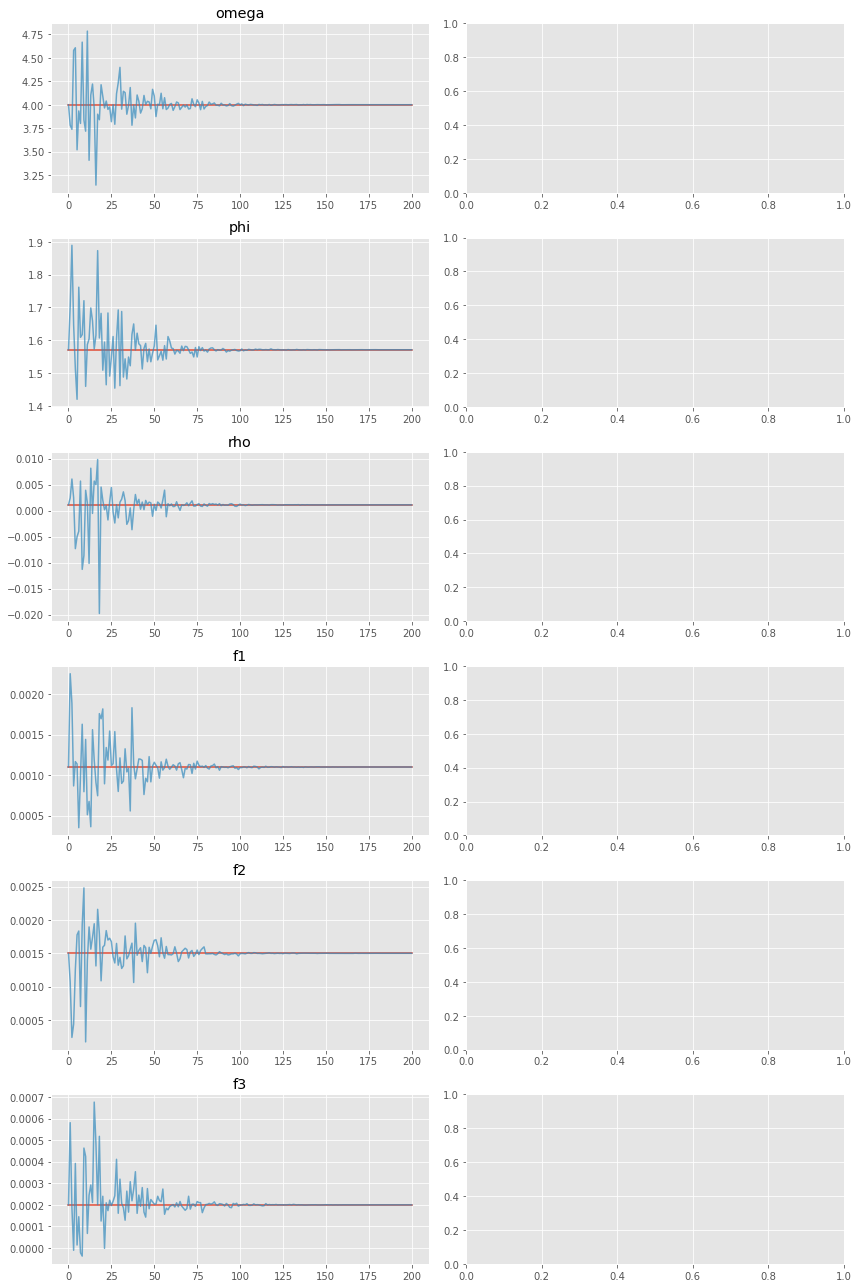

In [11]:
# gb = gelman_rubin(make_chains(mcmc))
# print (gb)
names = ['omega','phi','rho','f1','f2','f3']
fig, axs = plt.subplots(len(names),2, figsize=(12,18))

# axs = np.hstack(axs)
for j, mcmc in enumerate(mcmcs[:1]):
    chain = mcmc['chain'][:,:]
    guess = mcmc['guesses'][:,:]
    for i, name in enumerate(names):
        axs[i,0].plot(chain[:,i], label = 'chain {}'.format(j))
        axs[i,0].plot(guess[:,i], label = 'chain {}'.format(j), alpha=0.7)
        
        axs[i,0].set_title(name)

#         density = kde(chain[:,i])
#         xs = np.linspace(-5,5,50)
#         axs[i,1].plot(xs,density(xs))

plt.tight_layout()
plt.show()

In [26]:
len(mcmc0['chain'])

3001

In [69]:
m = M_now
plt.plot(months, m.sum(axis=0), 'r', lw=1)
plt.scatter(months, data1.sum(axis=0))
plt.show()

NameError: name 'M_now' is not defined

In [45]:
# m = mcmc['monthly'][5000:7000,:,:].mean(axis=0).sum(axis=0)
m = M_now.sum(axis=0)
plt.plot(months, m, 'r', lw=1)
plt.scatter(months, data1.sum(axis=0))


# m = mcmc['yearly'][5000:7000,:].mean(axis=0)
m = Y_now
print (m.size)
plt.plot(years, m/12, 'r', lw=1)
plt.scatter(years, data2/12, c='g')
plt.show()

NameError: name 'M_now' is not defined

[-1.     0.01   0.028  0.11   0.242  0.21   0.23 ]


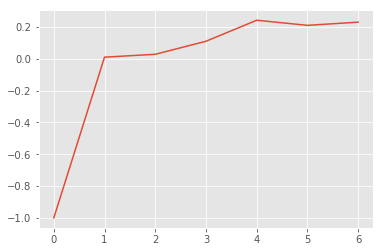

In [23]:
print (mcmc['rates'])
plt.plot(mcmc['rates'])
plt.show()

In [78]:
mcmc0['y_now_M'].shape

(3, 192)

In [79]:
for k,v in mcmc.items():
    if k in ['chain','monthly', 'y_now_M', 'y_hat_M']:
        continue
    print (k,'\n',v,'\n\n\n')
print (mcmc['accepted'].size)

cov 
 [[ 0.     -0.0001  0.      0.      0.      0.      0.    ]
 [-0.0001  0.0005 -0.0002 -0.     -0.     -0.     -0.    ]
 [ 0.     -0.0002  0.0001  0.      0.      0.      0.0001]
 [ 0.     -0.      0.      0.      0.      0.      0.    ]
 [ 0.     -0.      0.      0.      0.      0.      0.    ]
 [ 0.     -0.      0.      0.      0.      0.      0.    ]
 [ 0.     -0.      0.0001  0.      0.      0.      0.0003]] 



accepted 
 [1 1 1 1 1 0 1 0 1 0 ..., 0 0 0 0 0 0 0 0 0 0] 



d 
 7 



sigma 
 100 



gelman_rubin 
 [ 0.  0.  0.  0.  0.  0.  0.] 



active 
 True 



rates 
 [ 0.     0.088  0.01   0.     0.004  0.     0.002  0.004  0.002  0.002  0.01   0.004  0.018  0.008  0.008] 



scaling_factor 
 [ 0.9071  0.787   0.7051  0.653   0.6171  0.5894  0.5674  0.5494  0.534   0.5206  0.5093  0.4989  0.4902  0.4819  0.4743] 



ll 
 [[     -inf      -inf]
 [-275.7242 -274.7789]
 [-274.7789 -274.3413]
 [-274.3413 -274.6733]
 [-274.6733 -275.8104]
 [-275.8104 -277.863 ]
 [-275.8104 -275

# Plots

In [16]:
# PLOT
fig, axs = mu_chart(tr_mu * m_p, data1)

NameError: name 'tr_mu' is not defined

In [89]:
fig1, ax1 = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=True)
plt.show()

NameError: name 'x' is not defined

In [117]:
fig2, ax2 = draw_model(x, y[0:3], ["Susceptible", "Vaccinated ap", "Vaccinated wp"], split=False, collapse=True)
plt.show()

NameError: name 'x' is not defined

In [87]:
fig3, ax3 = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=True)
# ax3[0].scatter(years, data_years / 12)
ax3[0].scatter(months, data.sum(axis=1), c='green')
ax3[0].set_xlim([2000, 2015])
ax3[0].set_ylim(0, 0.05)
plt.show()

NameError: name 'x' is not defined